In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Parameter
N = 30           # Anzahl Gitterpunkte
M = 5            # jeder M-te Punkt wird beobachtet
K = 3            # K-Nachbarn
num_epochs = 201
num_samples = 200
lr = 0.01

# Gitterpunkte
x_grid = torch.linspace(0, np.pi, N)

# K-Nachbar-Kanten (mit Self-Loop)
edges = []
for i in range(N):
    edges.append((i, i))  # Self-loop
    for k in range(1, K + 1):
        if i - k >= 0:
            edges.append((i, i - k))
        if i + k < N:
            edges.append((i, i + k))
edge_index = torch.tensor(edges).T  # [2, num_edges]

# GNN-Definition
class GNNLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.self_lin = nn.Linear(dim, dim)
        self.neigh_lin = nn.Linear(dim, dim)

    def forward(self, x, edge_index):
        row, col = edge_index
        agg = torch.zeros_like(x)
        agg.index_add_(0, row, x[col])
        return F.relu(self.self_lin(x) + self.neigh_lin(agg))

class GNN(nn.Module):
    def __init__(self, in_dim=3, hidden=64):
        super().__init__()
        self.input_proj = nn.Linear(in_dim, hidden)
        self.gnn1 = GNNLayer(hidden)
        self.gnn2 = GNNLayer(hidden)
        self.out = nn.Linear(hidden, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.input_proj(x))
        x = self.gnn1(x, edge_index)
        x = self.gnn2(x, edge_index)
        return self.out(x).squeeze(-1)

# Initialisierung
model = GNN(in_dim=3)
opt = torch.optim.Adam(model.parameters(), lr=lr)

# Training
for epoch in range(num_epochs):
    losses = []
    for _ in range(num_samples):
        # Zufällige Sinus- oder Cosinus-Funktion mit Phase
        phase = torch.rand(1).item() * np.pi
        f_type = torch.randint(0, 2, (1,)).item()
        f = lambda x: torch.sin(x + phase) if f_type == 0 else torch.cos(x + phase)
        y_true = f(x_grid)

        # Beobachtung alle M Punkte
        mask = torch.zeros(N)
        mask[::M] = 1.0
        obs_y = y_true * mask

        # Eingabe-Features: [x, val, mask]
        x_feat = torch.stack([x_grid, obs_y, mask], dim=1)

        # Training
        model.train()
        pred = model(x_feat, edge_index)
        loss = F.mse_loss(pred, y_true)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {np.mean(losses):.6f}")


Epoch 0: Loss = 1.479758
Epoch 50: Loss = 0.010223
Epoch 100: Loss = 0.010418
Epoch 150: Loss = 0.008370
Epoch 200: Loss = 0.009298


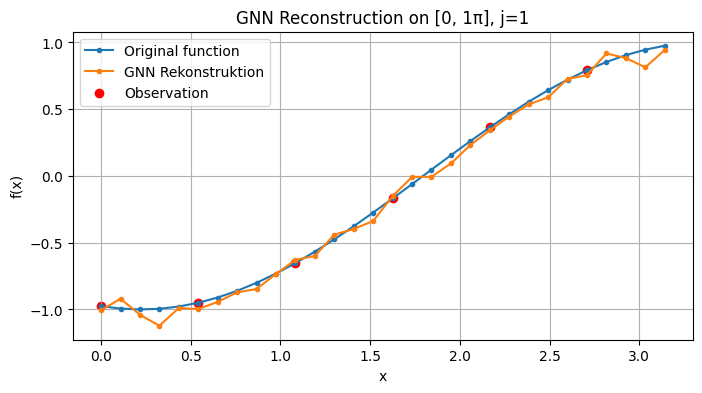

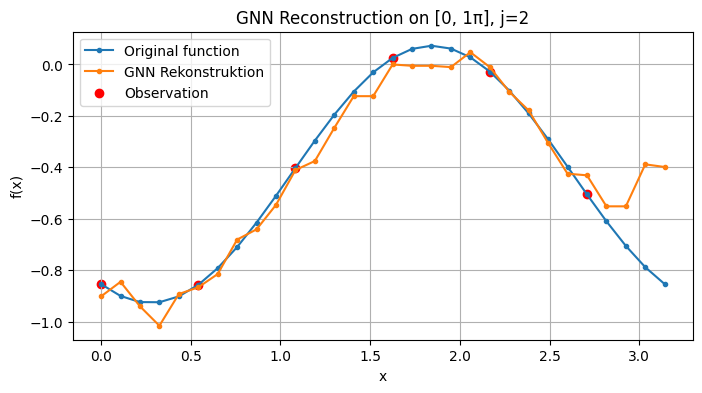

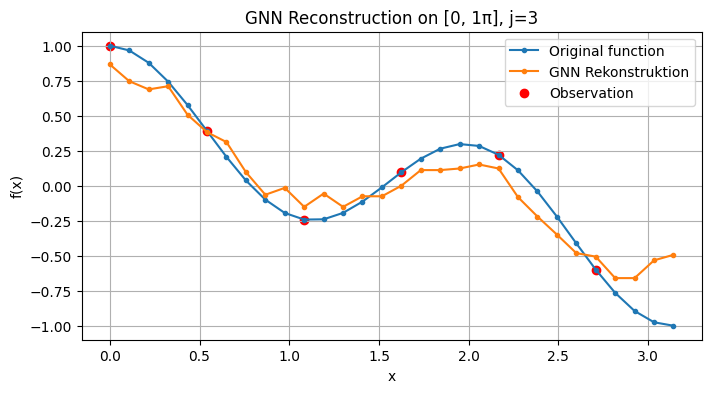

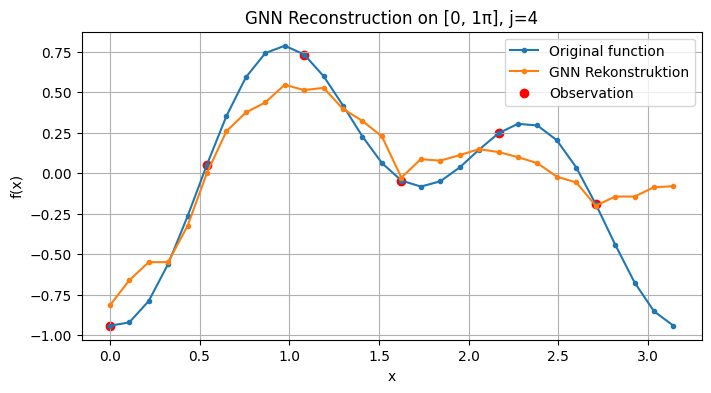

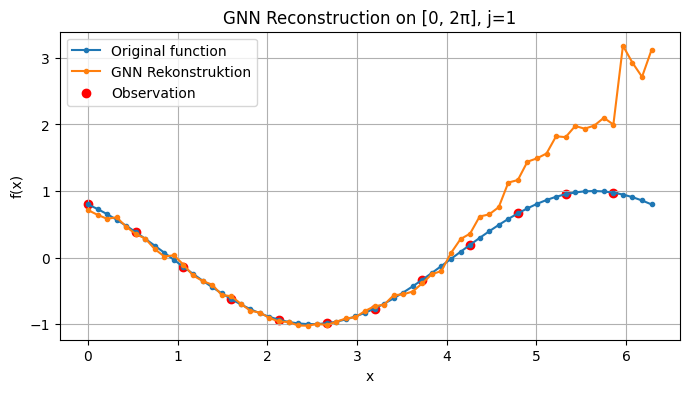

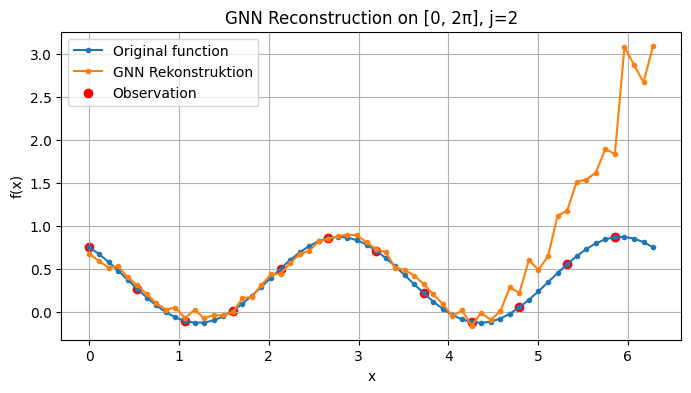

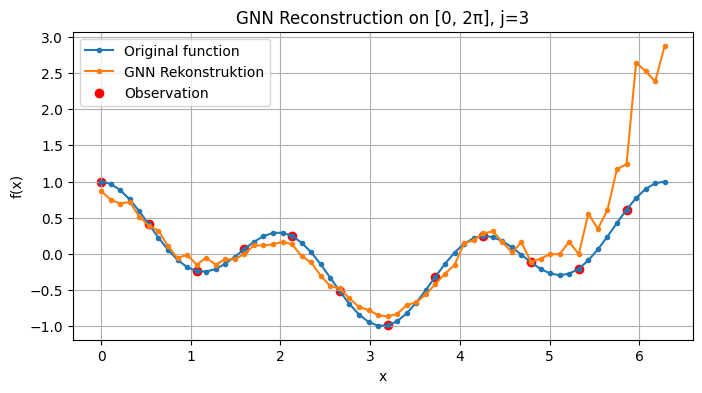

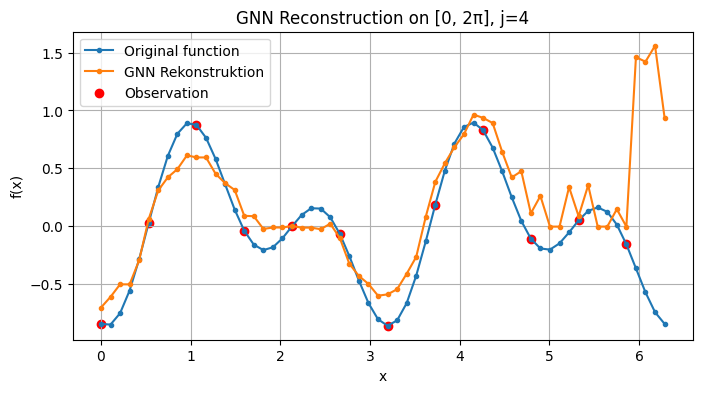

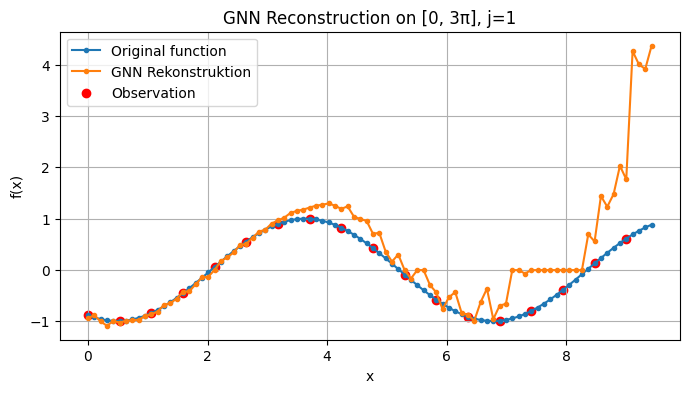

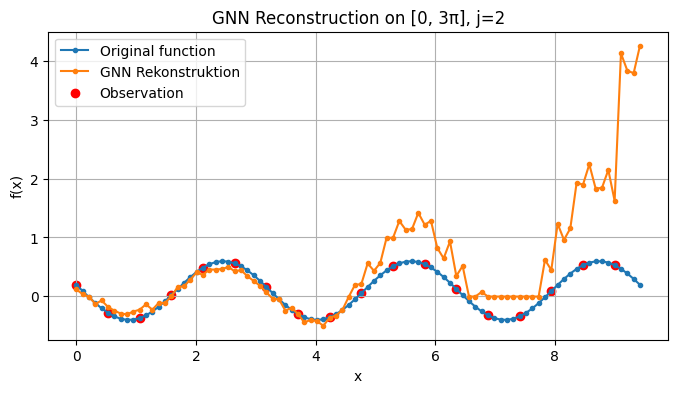

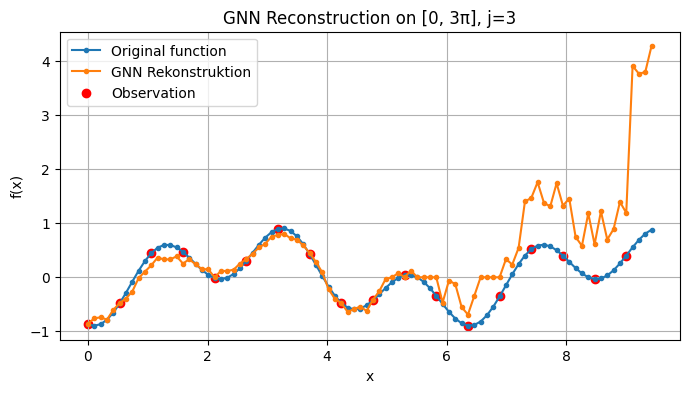

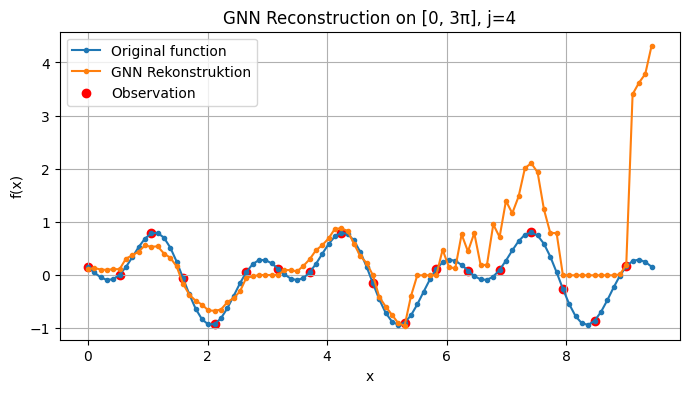

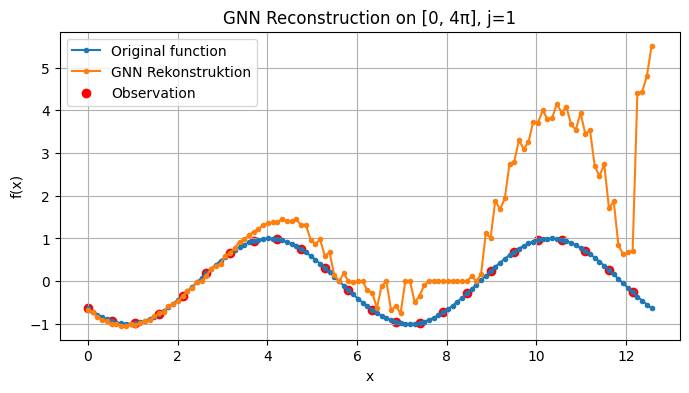

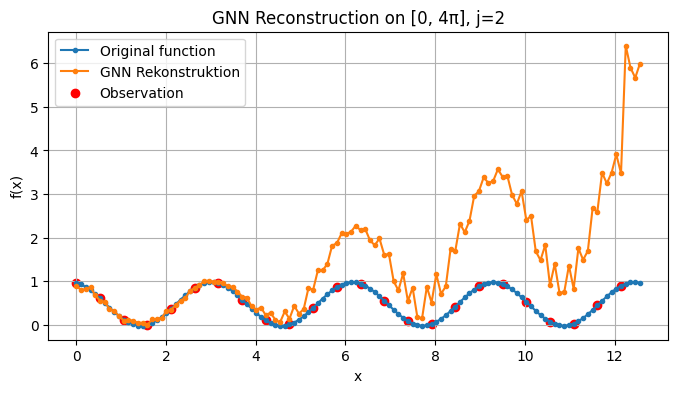

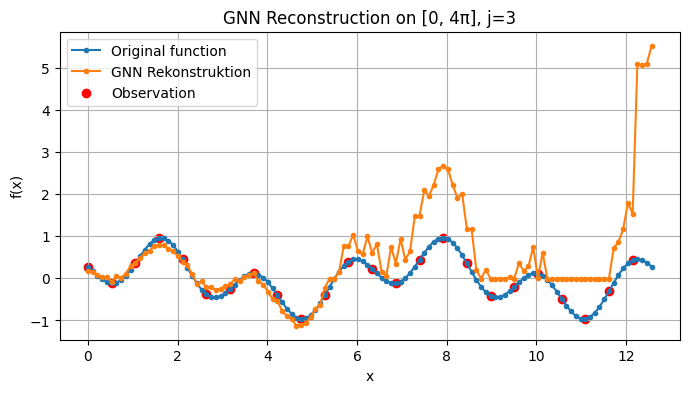

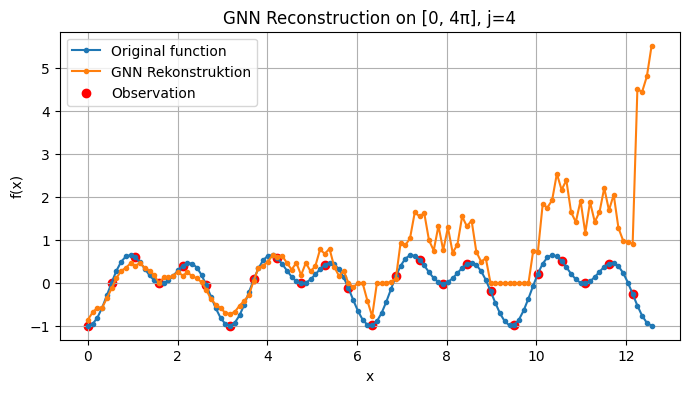

In [19]:
def run_test(j, jj, tag):
    N_test = jj * 30
    x_test_grid = torch.linspace(0, jj * np.pi, N_test)

    # Neue Testfunktion mit zufälliger Phase
    phi_test = torch.rand(1).item() * np.pi
    f_test = lambda x: torch.cos(x + phi_test) * torch.cos((j - 1) * x)
    y_test = f_test(x_test_grid)

    # Beobachtungen nur an jedem M-ten Punkt
    mask = torch.zeros(N_test)
    mask[::M] = 1.0
    obs = y_test * mask

    # Eingabe-Features: [x, val, mask]
    x_feat_test = torch.stack([x_test_grid, obs, mask], dim=1)

    # K-Nachbarn + Self-Loops für neuen Bereich
    edges = []
    for i in range(N_test):
        edges.append((i, i))  # Self-loop
        for k in range(1, K + 1):
            if i - k >= 0:
                edges.append((i, i - k))
            if i + k < N_test:
                edges.append((i, i + k))
    edge_index_test = torch.tensor(edges).T

    # Vorhersage
    model.eval()
    with torch.no_grad():
        pred_test = model(x_feat_test, edge_index_test)

    # Visualisierung
    plt.figure(figsize=(8, 4))
    plt.plot(x_test_grid, y_test, '.-', label="Original function")
    plt.plot(x_test_grid, pred_test, '.-', label="GNN Rekonstruktion")
    plt.scatter(x_test_grid[::M], y_test[::M], color='red', label="Observation")
    plt.title(f"GNN Reconstruction on [0, {jj}π], j={j}")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.grid(True)
    plt.legend()
    plt.savefig(f"gnn_obs_naive_j{j}_jj{jj}_{tag}.png")
    plt.show()

# Anwendung auf mehrere Intervalle und Frequenzen
for j in range(1, 5):
    run_test(1, j, 0)
    run_test(2, j, 0)
    run_test(3, j, 0)
    run_test(4, j, 0)


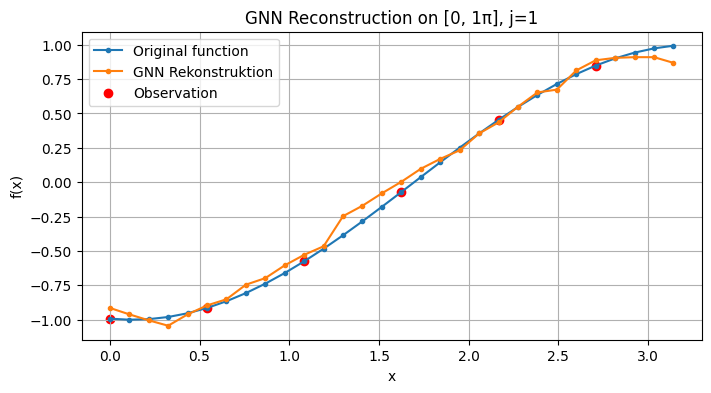

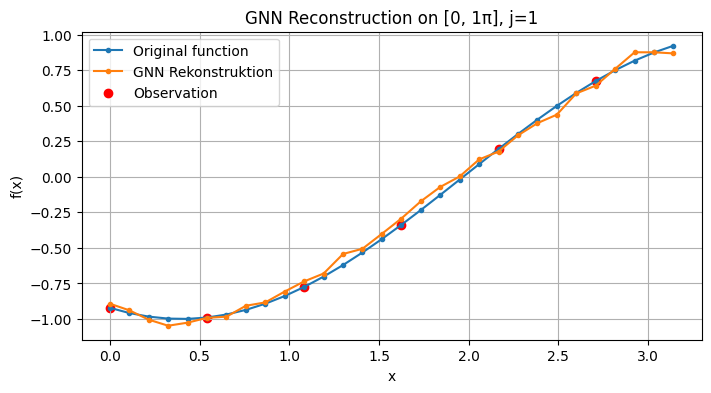

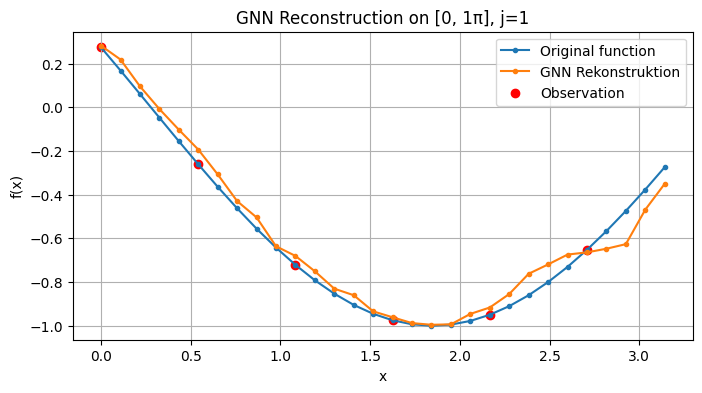

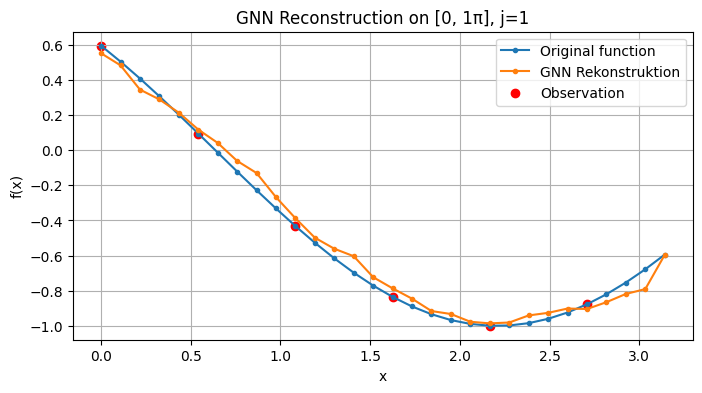

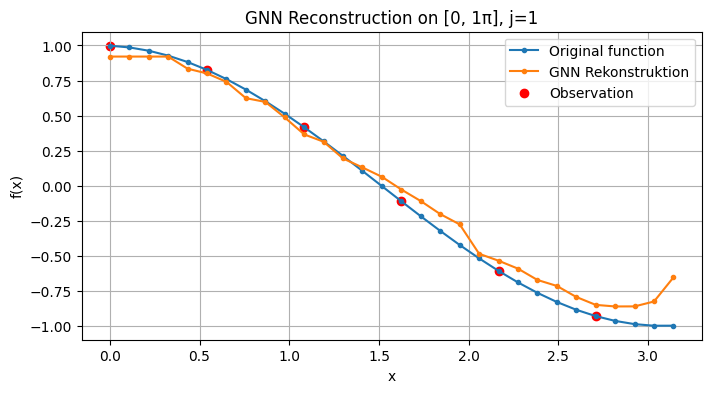

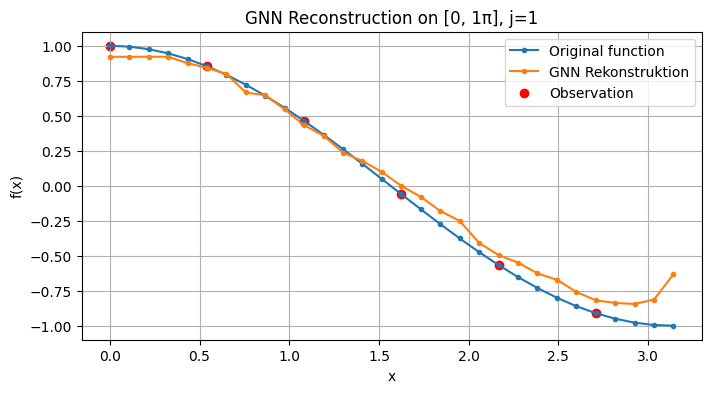

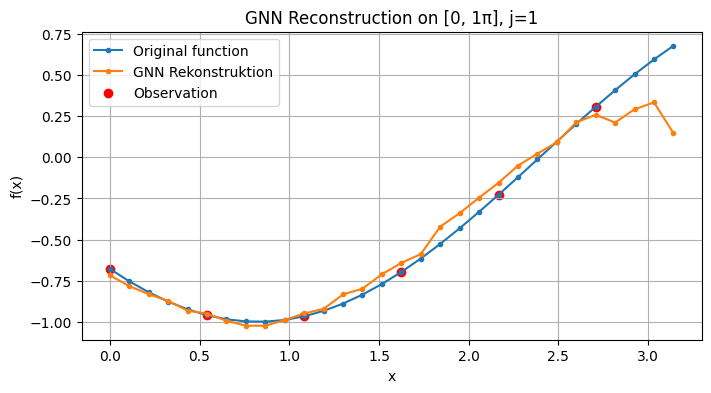

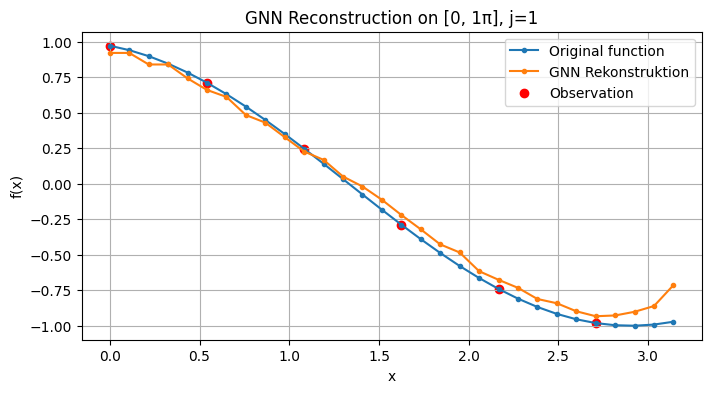

In [14]:
# Anwendung auf mehrere Intervalle und Frequenzen
for xi in range(1, 9):
    run_test(1, 1, xi)

# Remove dependence on variable x

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Parameter
N = 30           # Anzahl Gitterpunkte
M = 5            # jeder M-te Punkt wird beobachtet
K = 3            # K-Nachbarn
num_epochs = 201
num_samples = 200
lr = 0.01

# Gitterpunkte
x_grid = torch.linspace(0, np.pi, N)

# K-Nachbar-Kanten (mit Self-Loop)
edges = []
for i in range(N):
    edges.append((i, i))  # Self-loop
    for k in range(1, K + 1):
        if i - k >= 0:
            edges.append((i, i - k))
        if i + k < N:
            edges.append((i, i + k))
edge_index = torch.tensor(edges).T  # [2, num_edges]

# GNN-Definition
class GNNLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.self_lin = nn.Linear(dim, dim)
        self.neigh_lin = nn.Linear(dim, dim)

    def forward(self, x, edge_index):
        row, col = edge_index
        agg = torch.zeros_like(x)
        agg.index_add_(0, row, x[col])
        return F.relu(self.self_lin(x) + self.neigh_lin(agg))

class GNN(nn.Module):
    def __init__(self, in_dim=2, hidden=64):
        super().__init__()
        self.input_proj = nn.Linear(in_dim, hidden)
        self.gnn1 = GNNLayer(hidden)
        self.gnn2 = GNNLayer(hidden)
        self.out = nn.Linear(hidden, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.input_proj(x))
        x = self.gnn1(x, edge_index)
        x = self.gnn2(x, edge_index)
        return self.out(x).squeeze(-1)

# Initialisierung
model2 = GNN(in_dim=2)
opt = torch.optim.Adam(model2.parameters(), lr=lr)

# Training
for epoch in range(num_epochs):
    losses = []
    for _ in range(num_samples):
        # Zufällige Sinus- oder Cosinus-Funktion mit Phase
        phase = torch.rand(1).item() * np.pi
        f_type = torch.randint(0, 2, (1,)).item()
        f = lambda x: torch.sin(x + phase) if f_type == 0 else torch.cos(x + phase)
        y_true = f(x_grid)

        # Beobachtung alle M Punkte
        mask = torch.zeros(N)
        mask[::M] = 1.0
        obs_y = y_true * mask

        # Nur [val, mask] als Input
        x_feat = torch.stack([obs_y, mask], dim=1)

        # Training
        model2.train()
        pred = model2(x_feat, edge_index)
        loss = F.mse_loss(pred, y_true)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {np.mean(losses):.6f}")

Epoch 0: Loss = 1.235663
Epoch 50: Loss = 0.009823
Epoch 100: Loss = 0.010308
Epoch 150: Loss = 0.007836
Epoch 200: Loss = 0.007871


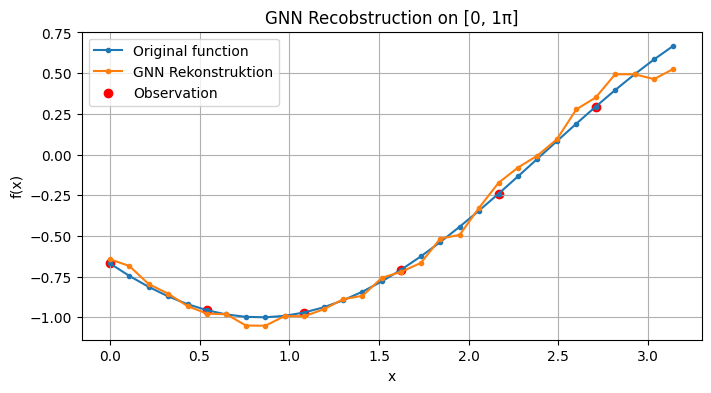

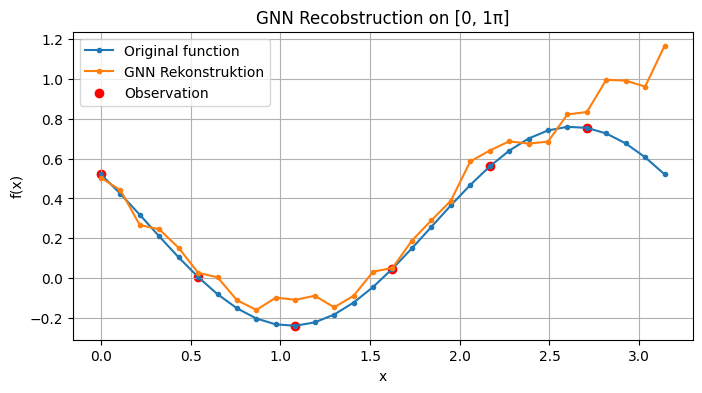

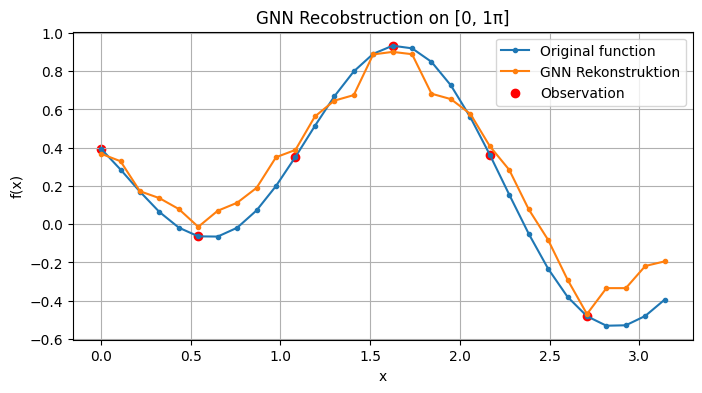

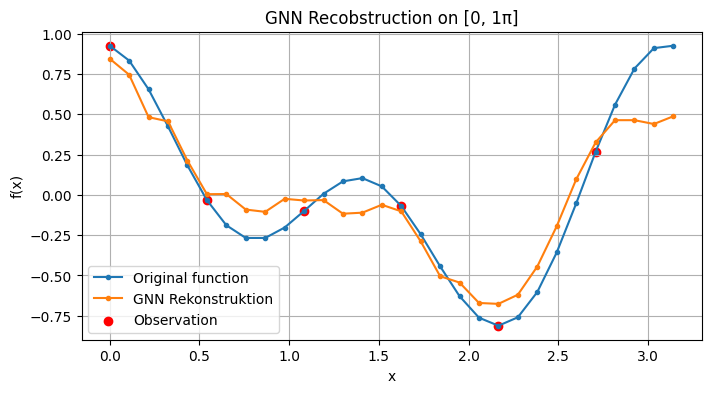

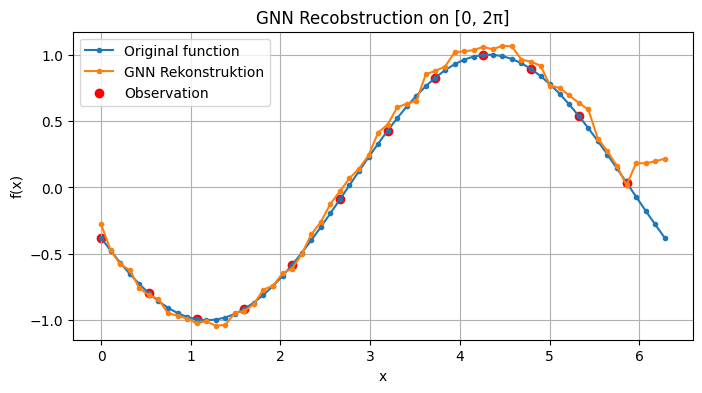

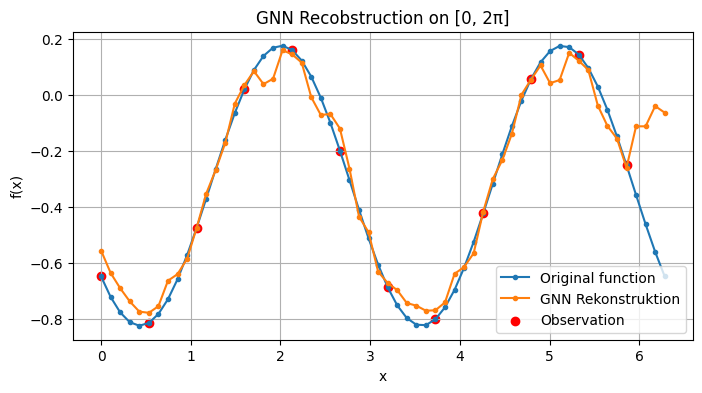

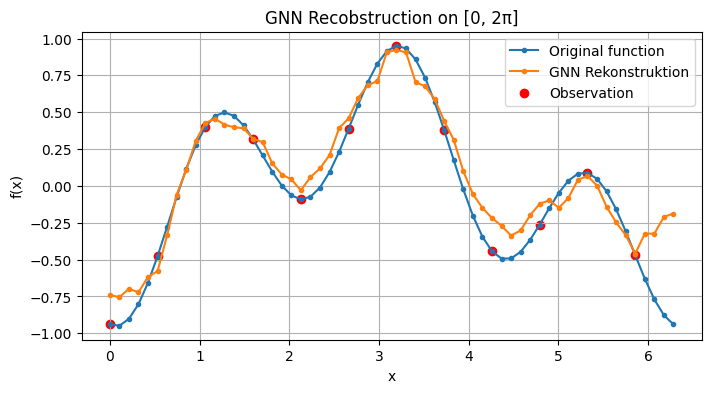

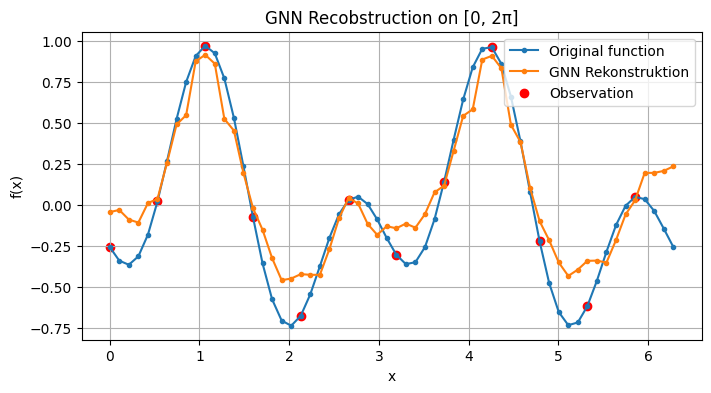

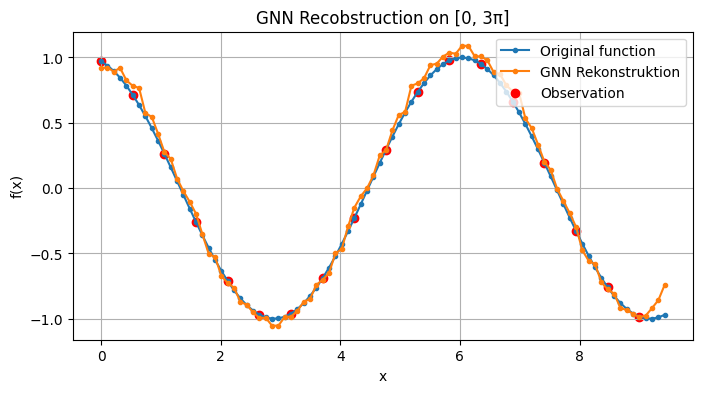

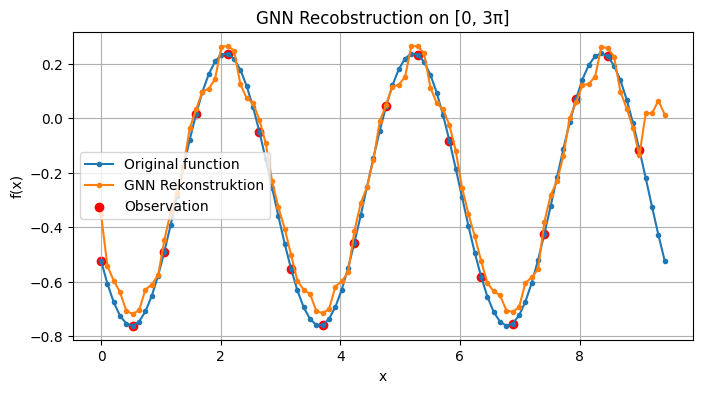

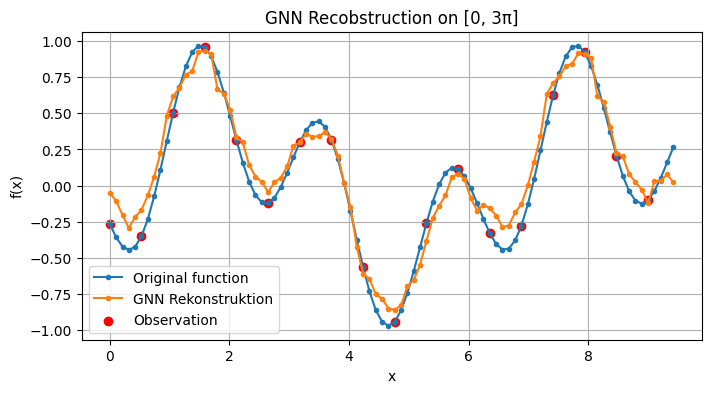

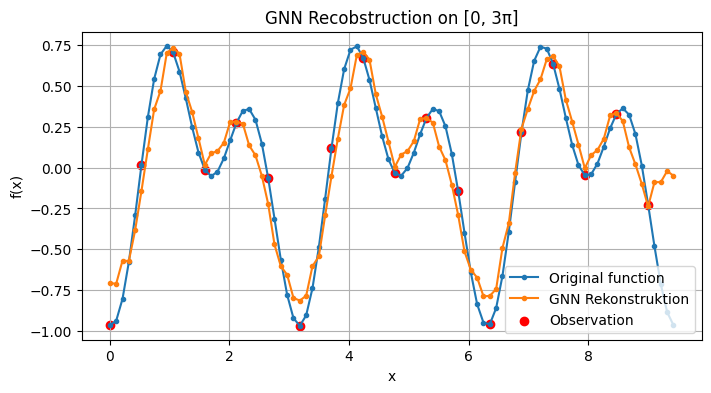

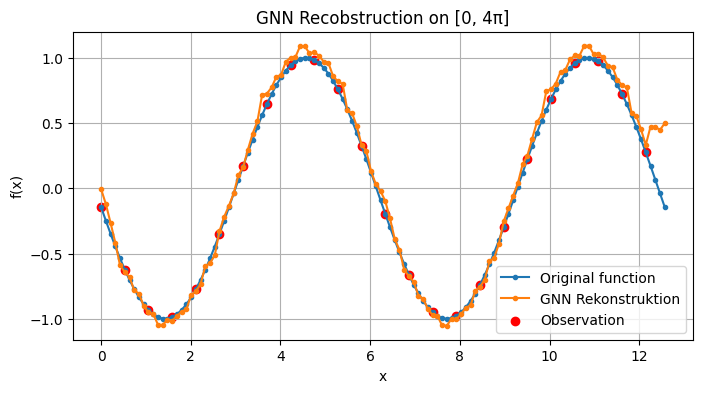

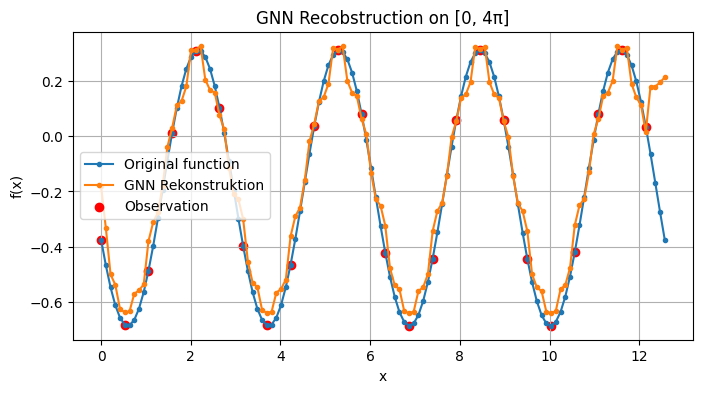

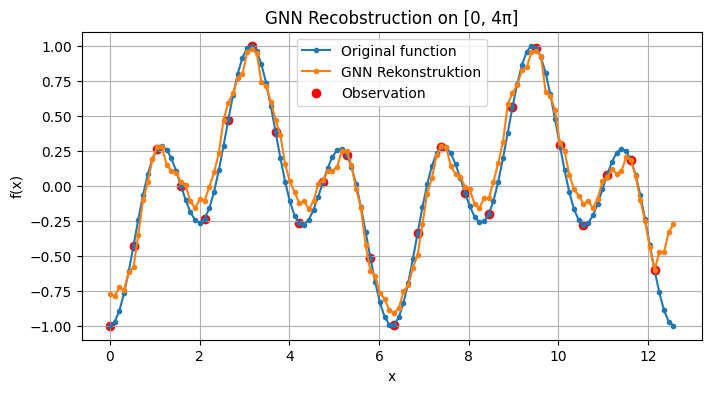

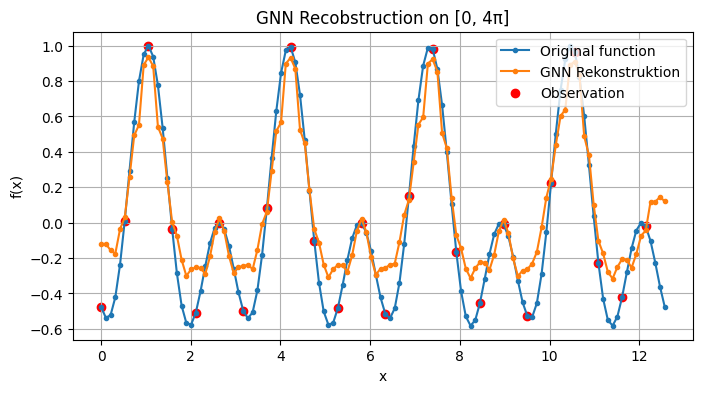

In [21]:
def run_test(j, jj,tag):
    N_test = jj * 30
    x_test_grid = torch.linspace(0, jj * np.pi, N_test)

    # Neue Testfunktion mit zufälliger Phase
    phi_test = torch.rand(1).item() * np.pi
    f_test = lambda x: torch.cos(x + phi_test) \
        * torch.cos((j-1)*x)
    y_test = f_test(x_test_grid)

    # Beobachtungen nur an jedem M-ten Punkt
    mask = torch.zeros(N_test)
    mask[::M] = 1.0
    obs = y_test * mask
    x_feat_test = torch.stack([obs, mask], dim=1)

    # K-Nachbarn + Self-Loops
    edges = []
    for i in range(N_test):
        edges.append((i, i))  # Self-loop
        for k in range(1, K + 1):
            if i - k >= 0:
                edges.append((i, i - k))
            if i + k < N_test:
                edges.append((i, i + k))
    edge_index_test = torch.tensor(edges).T

    # Vorhersage
    model2.eval()
    with torch.no_grad():
        pred_test = model2(x_feat_test, edge_index_test)

    # Visualisierung
    plt.figure(figsize=(8, 4))
    plt.plot(x_test_grid, y_test, '.-', label="Original function")
    plt.plot(x_test_grid, pred_test, '.-', label="GNN Rekonstruktion")
    plt.scatter(x_test_grid[::M], y_test[::M], color='red', label="Observation")
    plt.title(f"GNN Recobstruction on [0, {jj}π]")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.grid(True)
    plt.legend()
    plt.savefig(f"gnn_obs_no_pos_j{j}_jj{jj}_{tag}.png")
    plt.show()

# Anwendung auf zwei Intervalle
for j in range(1,5):
   run_test(1,j,0)
   run_test(2,j,0)
   run_test(3,j,0)
   run_test(4,j,0)

# Explore Graph Parameter Size

In [22]:
sum([param.nelement() for param in model.parameters()])

16961

In [23]:
sum([param.nelement() for param in model2.parameters()])

16897

In [37]:
def simple_param_summary(model):
    print('-'*80)
    total = 0
    print("Layer Summary:")
    for name, param in model.named_parameters():
        count = param.numel()
        total += count
        print(f"{name:30} | shape: {list(param.shape)} | params: {count}")
    print(f"\nTotal trainable parameters: {total}")

simple_param_summary(model)   
simple_param_summary(model2)  

--------------------------------------------------------------------------------
Layer Summary:
input_proj.weight              | shape: [64, 3] | params: 192
input_proj.bias                | shape: [64] | params: 64
gnn1.self_lin.weight           | shape: [64, 64] | params: 4096
gnn1.self_lin.bias             | shape: [64] | params: 64
gnn1.neigh_lin.weight          | shape: [64, 64] | params: 4096
gnn1.neigh_lin.bias            | shape: [64] | params: 64
gnn2.self_lin.weight           | shape: [64, 64] | params: 4096
gnn2.self_lin.bias             | shape: [64] | params: 64
gnn2.neigh_lin.weight          | shape: [64, 64] | params: 4096
gnn2.neigh_lin.bias            | shape: [64] | params: 64
out.weight                     | shape: [1, 64] | params: 64
out.bias                       | shape: [1] | params: 1

Total trainable parameters: 16961
--------------------------------------------------------------------------------
Layer Summary:
input_proj.weight              | shape: [64, 2] 

In [41]:
print(model)

GNN(
  (input_proj): Linear(in_features=3, out_features=64, bias=True)
  (gnn1): GNNLayer(
    (self_lin): Linear(in_features=64, out_features=64, bias=True)
    (neigh_lin): Linear(in_features=64, out_features=64, bias=True)
  )
  (gnn2): GNNLayer(
    (self_lin): Linear(in_features=64, out_features=64, bias=True)
    (neigh_lin): Linear(in_features=64, out_features=64, bias=True)
  )
  (out): Linear(in_features=64, out_features=1, bias=True)
)


# Graph Structure Visualization

In [43]:
from torchviz import make_dot

out = model(x_dummy, edge_index_dummy)
make_dot(out, params=dict(model.named_parameters())).render("gnn_structure", format="png")

'gnn_structure.png'